In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import requests
import io
import seaborn as sns
from tqdm.notebook import tqdm
import community as community_louvain
import os
from zipfile import ZipFile
from scipy.stats import fisher_exact
import numpy as np
from statsmodels.stats.multitest import multipletests
import random
import matplotlib.pyplot as plt

In [2]:
%run utility.ipynb

In [3]:
# Load BioGRID data
biogrid_zip_file = 'BIOGRID-MV-Physical-4.4.245.tab2.zip'
biogrid_df = load_biogrid_data(biogrid_zip_file)
display(biogrid_df.head())

# Create PPI network
ppi_network = create_ppi_network(biogrid_df, interaction_type='physical')

# Load disease groups
disease_groups_file = 'bones_disease_genes.csv'
print("\n=========================================")
print("Loading disease groups and their genes")
disease_df = pd.read_csv(disease_groups_file, sep='\t')
display(disease_df)
# Check if all genes are unique
total_genes = len(disease_df['gene'])
unique_genes = len(disease_df['gene'].unique())
print(f"Total genes: {total_genes}")
print(f"Unique genes: {unique_genes}")
# If there are duplicates, show them
if total_genes != unique_genes:
    duplicates = disease_df[disease_df['gene'].duplicated(keep=False)].sort_values('gene')
    print(f"\nDuplicate genes found:")
    with pd.option_context('display.max_rows', None):
        display(duplicates)

Loading BioGRID data
Using file: BIOGRID-MV-Physical-4.4.245.tab2.txt
Loaded 318015 human ppi-interactions

Experimental System Distribution (Total: 318015 interactions):
--------------------------------------------------------------------------------
System Type                              |      Count | Percentage
--------------------------------------------------------------------------------
Affinity Capture-MS                      |    124,227 |     39.06%
Affinity Capture-Western                 |     61,914 |     19.47%
Proximity Label-MS                       |     28,720 |      9.03%
Reconstituted Complex                    |     27,385 |      8.61%
Co-fractionation                         |     22,161 |      6.97%
Two-hybrid                               |     21,778 |      6.85%
Biochemical Activity                     |      9,542 |      3.00%
Cross-Linking-MS (XL-MS)                 |      8,267 |      2.60%
Co-localization                          |      3,648 |      1.1

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,Pubmed ID,Organism Interactor A,Organism Interactor B,Throughput,Score,Modification,Phenotypes,Qualifications,Tags,Source Database
0,103,6416,2318,112315,108607,-,-,MAP2K4,FLNC,JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAP...,...,9006895,9606,9606,Low Throughput,-,-,-,-,-,BIOGRID
1,278,2624,5371,108894,111384,-,-,GATA2,PML,DCML|IMD21|MONOMAC|NFE1B,...,10938104,9606,9606,Low Throughput,-,-,-,-,-,BIOGRID
2,418,6118,6774,112038,112651,RP4-547C9.3,-,RPA2,STAT3,REPA2|RP-A p32|RP-A p34|RPA32,...,10875894,9606,9606,Low Throughput,-,-,-,-,-,BIOGRID
3,586,375,23163,106870,116775,-,-,ARF1,GGA3,-,...,10747089,9606,9606,Low Throughput,-,-,-,-,-,BIOGRID
4,612,377,23647,106872,117174,-,-,ARF3,ARFIP2,-,...,9038142,9606,9606,Low Throughput,-,-,-,-,-,BIOGRID


Building network with 318015 physical interactions...


  0%|          | 0/318015 [00:00<?, ?it/s]

Network created with 11553 nodes and 89993 edges
  Interactions with missing symbols: 0
  Self-interactions: 5931
  Duplicate edges: 222091
  Unique edges added: 89993
  Sum: 318015

Loading disease groups and their genes


,gene,group_number,group_description
0,FGFR3,1,FGFR3 chondrodysplasias
1,COL2A1,2,Type 2 collagen disorders
2,COL11A1,3,Type 11 collagen disorders
3,COL11A2,3,Type 11 collagen disorders
4,SLC26A2,4,Sulfation disorders
...,...,...,...
599,GDF6,41,Defects in joint formation and synostoses
600,PITX1,41,Defects in joint formation and synostoses
601,GSC,41,Defects in joint formation and synostoses
602,HOXA11,41,Defects in joint formation and synostoses


Total genes: 604
Unique genes: 549

Duplicate genes found:


,gene,group_number,group_description
426,ACTB,31,Overgrowth (tall stature) syndromes and segmen...
499,ACTB,35,Craniofacial dysostoses
438,ALX4,33,Cleidocranial dysplasia and related disorders
483,ALX4,35,Craniofacial dysostoses
367,ANKH,27,Disorders of bone mineralisation
290,ANKH,25,Osteosclerotic disorders
588,BHLHA9,40,Polydactyly‐Syndactyly‐Triphalangism group
567,BHLHA9,39,Split hand/foot with and without other manifes...
166,BMPR1B,18,Brachydactylies (isolated)
151,BMPR1B,16,Acromesomelic dysplasias


In [4]:
def detect_global_communities_and_analyze_disease_group(G, communities, diseases_df, target_group_number,
                                                        gene_column="gene", 
                                                        group_number_column="group_number", 
                                                        group_description_column="group_description"):
    """
    Detect communities in the whole PPI network and analyzes how genes from a specific disease group
    are distributed across these communities.
    
    Parameters:
    G (networkx.Graph): Full PPI network
    communities: List of communities (sets of proteins)
    diseases_df (pandas.DataFrame): DataFrame containing genes for multiple disease groups
    target_group_number (int): Specific disease group number to analyze
    gene_column (str): Column name in DataFrame containing gene symbols
    group_number_column (str): Column name containing group numbers
    group_description_column (str): Column name containing group descriptions
    
    Returns:
    pandas.DataFrame: Community statistics with enrichment results for the target group
    """
    # Check if required columns exist
    required_columns = [gene_column, group_number_column, group_description_column]
    missing_columns = [col for col in required_columns if col not in diseases_df.columns]
    if missing_columns:
        print(f"Missing columns: {', '.join(missing_columns)}")
        print(f"Available columns: {', '.join(diseases_df.columns)}")
        return None
    
    # Check if DataFrame is empty
    if diseases_df.empty:
        print("Empty DataFrame provided")
        return None
    
    # Filter for target group
    target_group_df = diseases_df[diseases_df[group_number_column] == target_group_number]
    if target_group_df.empty:
        print(f"No genes found for group number {target_group_number}")
        available_groups = diseases_df[group_number_column].unique()
        print(f"Available groups: {sorted(available_groups)}")
        return None
    
    # Get group information
    group_description = target_group_df[group_description_column].iloc[0]
    
    # Extract genes for target group
    genes_of_interest = set(target_group_df[gene_column].dropna().unique())
    genes_in_network = genes_of_interest.intersection(set(G.nodes()))
    
    print(f"Analyzing disease group {target_group_number}: {group_description}")
    print(f"Loaded {len(genes_of_interest)} genes from group")
    print(f"Found {len(genes_in_network)} of these genes in the network")
    
    if len(genes_in_network) == 0:
        print("No genes from this group found in the network")
        return None
    
    # Create statistics about communities for the target disease group
    community_stats = []
    for i, community in enumerate(communities):
        size = len(community)
        # Find genes from target group in this community
        target_genes_in_community = community.intersection(genes_in_network)
        community_stats.append({
            'Community_ID': i,
            'Size': size,
            'Target_Group_Genes': len(target_genes_in_community),
            'Percentage_Of_Community': (len(target_genes_in_community) / size) * 100 if size > 0 else 0,
            'Percentage_Of_Target_Group': (len(target_genes_in_community) / len(genes_in_network)) * 100 if len(genes_in_network) > 0 else 0,
            'Target_Genes_List': list(target_genes_in_community)
        })
    
    # Convert to DataFrame
    stats_df = pd.DataFrame(community_stats)
    
    # Calculate Fisher's exact test for enrichment of target group in each community
    total_nodes = G.number_of_nodes()
    total_target_genes = len(genes_in_network)
    
    p_values = []
    odds_ratios = []
    
    for _, row in stats_df.iterrows():
        # Build contingency table
        a = row['Target_Group_Genes']  # Target group genes in community
        b = row['Size'] - a  # Other genes in community
        c = total_target_genes - a  # Target group genes outside community
        d = total_nodes - total_target_genes - b  # Other genes outside community
        
        # Skip communities with no target genes
        if a == 0:
            p_values.append(1.0)
            odds_ratios.append(0.0)
            continue
        
        table = np.array([[a, b], [c, d]])
        # Test for overrepresentation
        odds_ratio, p_value = fisher_exact(table, alternative='greater')
        p_values.append(p_value)
        odds_ratios.append(odds_ratio)
    
    # Add to DataFrame
    stats_df['Enrichment_P_Value'] = p_values
    stats_df['Odds_Ratio'] = odds_ratios
    
    # Apply Benjamini-Hochberg correction
    if len(p_values) > 0:
        _, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')
        stats_df['Adjusted_P_Value'] = corrected_p_values
    
    # Sort by enrichment significance
    stats_df = stats_df.sort_values('Adjusted_P_Value')
    
    # Identify significantly enriched communities
    enriched_communities = stats_df[stats_df['Adjusted_P_Value'] < 0.05]['Community_ID'].tolist()
    print(f"Found {len(enriched_communities)} significantly enriched communities for disease group {target_group_number}")
    
    return stats_df

In [5]:
disease_groups = sorted(disease_df['group_number'].unique())

# Detect communities ONCE
print("Detecting communities in the PPI network...")
random.seed(42)  # Set seed once
communities = list(nx.algorithms.community.louvain_communities(ppi_network))
print(f"Detected {len(communities)} communities in the ppi network graph")

# Collect all results and p-values
all_results = {}
all_pvalues = [] # p-values for all group-community pairing
pvalue_mapping = []

for group_num in disease_groups:
    print("==================================================")
    stats = detect_global_communities_and_analyze_disease_group(ppi_network,
                                                                communities,
                                                                disease_df,
                                                                target_group_number=group_num)
    all_results[group_num] = stats
    
    if stats is not None:
        for idx, row in stats.iterrows():
            all_pvalues.append(row['Enrichment_P_Value'])
            pvalue_mapping.append((group_num, idx))

# Apply global correction
_, global_corrected_pvals, _, _ = multipletests(all_pvalues, method='fdr_bh')

# Update results with global correction
for i, (group_num, row_idx) in enumerate(pvalue_mapping):
    all_results[group_num].loc[row_idx, 'Global_Adjusted_P_Value'] = global_corrected_pvals[i]

# Display results
print("\n" + "="*60)
print("RESULTS AFTER GLOBAL P-VALUE CORRECTION")
print("="*60)

for group_num in disease_groups:
    stats = all_results[group_num]
    if stats is not None:
        enriched = stats[stats['Global_Adjusted_P_Value'] < 0.05]
        if not enriched.empty:
            print(f"\nGROUP {group_num} - Enriched communities:")
            display(enriched[['Community_ID', 'Size', 'Target_Group_Genes', 
                           'Global_Adjusted_P_Value', 'Odds_Ratio', 'Target_Genes_List']])
        else:
            print(f"\nGROUP {group_num}: No enriched communities")

print(f"\nGlobal correction applied to {len(all_pvalues)} p-values")

Detecting communities in the PPI network...
Detected 96 communities in the ppi network graph
Analyzing disease group 1: FGFR3 chondrodysplasias
Loaded 1 genes from group
Found 1 of these genes in the network
Found 0 significantly enriched communities for disease group 1
Analyzing disease group 2: Type 2 collagen disorders
Loaded 1 genes from group
Found 1 of these genes in the network
Found 0 significantly enriched communities for disease group 2
Analyzing disease group 3: Type 11 collagen disorders
Loaded 2 genes from group
Found 0 of these genes in the network
No genes from this group found in the network
Analyzing disease group 4: Sulfation disorders
Loaded 9 genes from group
Found 4 of these genes in the network
Found 0 significantly enriched communities for disease group 4
Analyzing disease group 5: Dysplasias with multiple joint dislocations
Loaded 9 genes from group
Found 6 of these genes in the network
Found 0 significantly enriched communities for disease group 5
Analyzing dis

,Community_ID,Size,Target_Group_Genes,Global_Adjusted_P_Value,Odds_Ratio,Target_Genes_List
7,7,560,21,5.192245e-17,38.897285,"[IFT172, IFT52, IFT81, PRKACB, IFT122, RPGRIP1..."



GROUP 11: No enriched communities

GROUP 12: No enriched communities

GROUP 13: No enriched communities

GROUP 14: No enriched communities

GROUP 15: No enriched communities

GROUP 16: No enriched communities

GROUP 17: No enriched communities

GROUP 18: No enriched communities

GROUP 19 - Enriched communities:


,Community_ID,Size,Target_Group_Genes,Global_Adjusted_P_Value,Odds_Ratio,Target_Genes_List
53,53,1687,10,0.029959,8.398501,"[ARID1A, SMARCA4, SMARCB1, TRPS1, SMARCE1, MYC..."



GROUP 20: No enriched communities

GROUP 21 - Enriched communities:


,Community_ID,Size,Target_Group_Genes,Global_Adjusted_P_Value,Odds_Ratio,Target_Genes_List
3,3,1345,12,0.034113,5.396584,"[ORC4, DONSON, ORC6, MCM5, DNA2, ORC1, TBCE, M..."



GROUP 22 - Enriched communities:


,Community_ID,Size,Target_Group_Genes,Global_Adjusted_P_Value,Odds_Ratio,Target_Genes_List
3,3,1345,9,0.000777,22.915419,"[IDUA, GBA, GNS, ARSK, GUSB, MAN2B1, AGA, SGSH..."



GROUP 23: No enriched communities

GROUP 24: No enriched communities

GROUP 25: No enriched communities

GROUP 26: No enriched communities

GROUP 27: No enriched communities

GROUP 28: No enriched communities

GROUP 29: No enriched communities

GROUP 30: No enriched communities

GROUP 31 - Enriched communities:


,Community_ID,Size,Target_Group_Genes,Global_Adjusted_P_Value,Odds_Ratio,Target_Genes_List
25,25,6,3,0.000342,523.863636,"[NPR2, NPR3, NPPC]"



GROUP 32: No enriched communities

GROUP 33: No enriched communities

GROUP 34: No enriched communities

GROUP 35: No enriched communities

GROUP 36: No enriched communities

GROUP 37: No enriched communities

GROUP 38 - Enriched communities:


,Community_ID,Size,Target_Group_Genes,Global_Adjusted_P_Value,Odds_Ratio,Target_Genes_List
53,53,1687,11,0.034113,6.468735,"[TOP2B, PITX1, NIPBL, SALL4, RBPJ, TBX3, NOTCH..."



GROUP 39: No enriched communities

GROUP 40: No enriched communities

GROUP 41: No enriched communities

Global correction applied to 3840 p-values


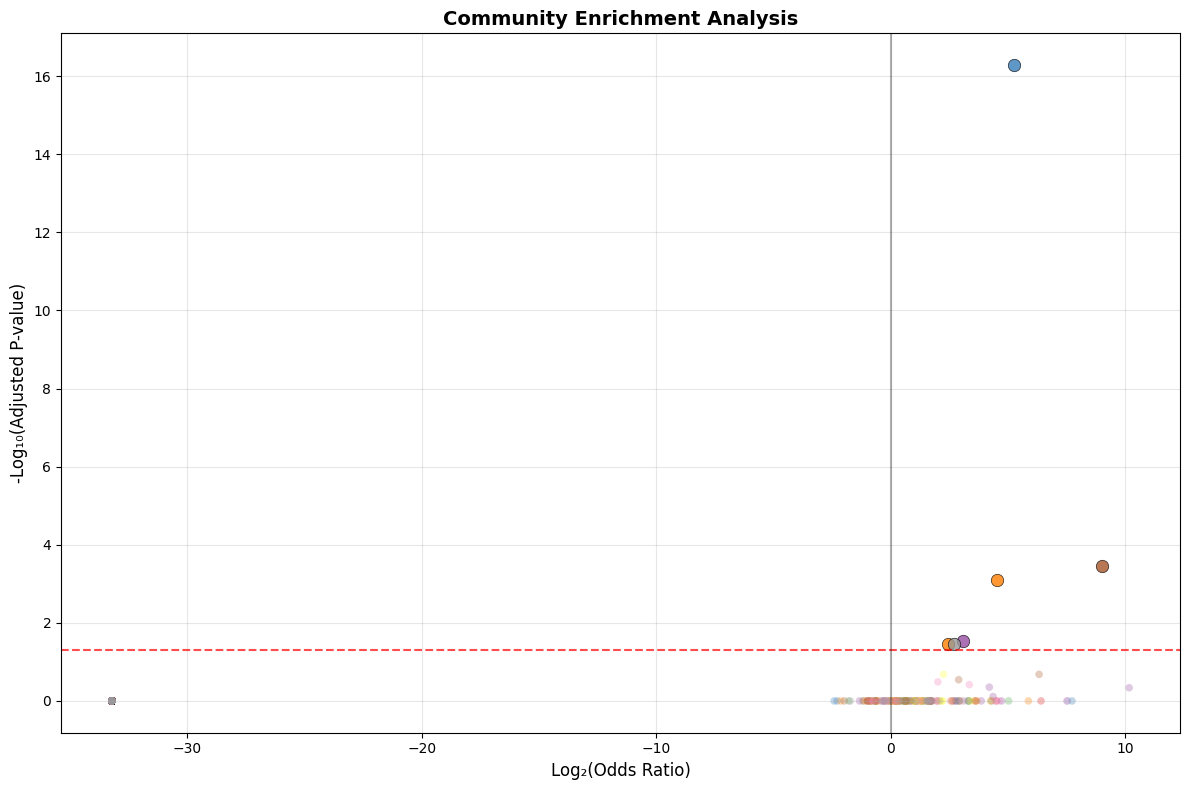


Enrichment Analysis Results:
Total communities tested: 3840
Significantly enriched (p < 0.05): 6 (0.2%)

Most enriched communities:
1. Group 10, Community 7: OR = 38.90, p = 5.19e-17
2. Group 31, Community 25: OR = 523.86, p = 3.42e-04
3. Group 22, Community 3: OR = 22.92, p = 7.77e-04


In [8]:
def create_volcano_plot(all_results, disease_groups, figsize=(12, 8)):
    """
    Create a focused plot for community enrichment analysis
    Each point represents the enrichment test for one disease-group-community pair
    """
    
    # Collect data
    plot_data = []
    
    for group_num in disease_groups:
        stats = all_results[group_num]
        if stats is not None and not stats.empty:
            for idx, row in stats.iterrows():
                # Handle undefined edge cases for log transformation
                odds_ratio = max(row['Odds_Ratio'], 1e-10)  # Avoid log(0)
                p_value = max(row['Global_Adjusted_P_Value'], 1e-50)  # Avoid log(0)
                
                plot_data.append({
                    'Disease_Group': group_num,
                    'Community_ID': row['Community_ID'],
                    'Odds_Ratio': odds_ratio,
                    'Global_Adjusted_P_Value': p_value,
                    'Log2_Odds_Ratio': np.log2(odds_ratio),
                    'Neg_Log10_P': -np.log10(p_value),  # Keep log10 for p-values
                    'Significant': p_value < 0.05,
                    'Community_Size': row['Size'],
                    'Target_Group_Genes': row['Target_Group_Genes']
                })
    
    if not plot_data:
        print("No data available for plotting")
        return
    
    df_plot = pd.DataFrame(plot_data)
    
    # Create the volcano plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Define colors for each disease group
    unique_groups = sorted(df_plot['Disease_Group'].unique())
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_groups)))
    color_map = dict(zip(unique_groups, colors))
    
    # Plot each disease group separately for better legend
    for group in unique_groups:
        group_data = df_plot[df_plot['Disease_Group'] == group]
        
        # Separate significant and non-significant
        sig_data = group_data[group_data['Significant']]
        non_sig_data = group_data[~group_data['Significant']]
        
        # Plot non-significant points (smaller, transparent)
        if not non_sig_data.empty:
            ax.scatter(non_sig_data['Log2_Odds_Ratio'], 
                      non_sig_data['Neg_Log10_P'],  # Use log10
                      c=[color_map[group]], alpha=0.3, s=30,
                      marker='o', edgecolors='none')
        
        # Plot significant points (larger, opaque)
        if not sig_data.empty:
            ax.scatter(sig_data['Log2_Odds_Ratio'], 
                      sig_data['Neg_Log10_P'],  # Use log10
                      c=[color_map[group]], alpha=0.8, s=80,
                      marker='o', edgecolors='black', linewidth=0.5,
                      label=f'Group {group}')
    
    # Add significance threshold line (optional but recommended)
    ax.axhline(y=-np.log10(0.05), color='red', linestyle='--', 
               alpha=0.7, label='p = 0.05')
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Customize the plot
    ax.set_xlabel('Log₂(Odds Ratio)', fontsize=12)
    ax.set_ylabel('-Log₁₀(Adjusted P-value)', fontsize=12)  # Keep log10
    ax.set_title('Community Enrichment Analysis', fontsize=14, fontweight='bold')
    
    # Add grid and legend
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print key statistics
    n_total = len(df_plot)
    n_significant = len(df_plot[df_plot['Significant']])
    
    print(f"\nEnrichment Analysis Results:")
    print(f"{'='*40}")
    print(f"Total communities tested: {n_total}")
    print(f"Significantly enriched (p < 0.05): {n_significant} ({n_significant/n_total*100:.1f}%)")
    
    if n_significant > 0:
        print(f"\nMost enriched communities:")
        top_results = df_plot[df_plot['Significant']].nsmallest(3, 'Global_Adjusted_P_Value')
        for i, (_, row) in enumerate(top_results.iterrows(), 1):
            print(f"{i}. Group {row['Disease_Group']}, Community {row['Community_ID']}: "
                  f"OR = {row['Odds_Ratio']:.2f}, p = {row['Global_Adjusted_P_Value']:.2e}")

create_volcano_plot(all_results, disease_groups)